In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [14]:
df = pd.read_csv('stroke_data.csv')
# print(df.head())

In [4]:
df.isnull().sum()

sex                  3
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [15]:
print(df['Residence_type'].unique())

[1 0]


In [6]:
df = df.dropna(subset=['sex'])

In [7]:
df.isnull().sum()

sex                  0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [8]:
df.value_counts('stroke')

stroke
1    20460
0    20447
Name: count, dtype: int64

In [9]:
print("BEFORE REMOVING NEGATIVE AGE : \n", df['age'].count())
negativeAge = df[df['age']<0]

print("\n\nNEGATIVE AGE VALUEsS : ")
print(negativeAge['age'].count())

df = df[df['age']>=0]
print("\n\nAFTER REMOVING NEGATIVE AGE :\n",df['age'].count())

BEFORE REMOVING NEGATIVE AGE : 
 40907


NEGATIVE AGE VALUEsS : 
58


AFTER REMOVING NEGATIVE AGE :
 40849


In [10]:
x = df.drop("stroke", axis = 1)
y = df["stroke"]

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


NameError: name 'X' is not defined

In [46]:

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
# Initialize empty set of selected features
selected_features = []

# Initialize list of remaining features
remaining_features = list(x.columns)

In [48]:
# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')


In [12]:
# RFA: Recursive Feature Addition
best_score = 0
while remaining_features:
    best_feature = None
    for feature in remaining_features:
        # Test with the current set of selected features + one additional feature
        temp_features = selected_features + [feature]
        
        # Select only the columns of the current features
        X_train_temp = X_train_scaled[:, [X.columns.get_loc(f) for f in temp_features]]
        X_test_temp = X_test_scaled[:, [X.columns.get_loc(f) for f in temp_features]]
        
        # Train the XGBoost model
        xgb_model.fit(X_train_temp, y_train)
        
        # Evaluate the model
        y_pred_temp = xgb_model.predict(X_test_temp)
        score = accuracy_score(y_test, y_pred_temp)
        
        # Check if this feature improves the performance
        if score > best_score:
            best_score = score
            best_feature = feature

    # If a feature was found that improves the score, add it to selected_features
    if best_feature:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        print(f'Added feature: {best_feature}, Score: {best_score:.4f}')
    else:
        # Stop if no improvement is found
        break

NameError: name 'remaining_features' is not defined

In [1]:

# Final model evaluation with selected features
print(f'Selected features: {selected_features}')

print(f'No. of feature selected: {len(selected_features)}')

print(df['Residence_type'].unique)

NameError: name 'selected_features' is not defined

In [51]:
# Train the XGBoost model with the selected features
X_train_final = X_train_scaled[:, [X.columns.get_loc(f) for f in selected_features]]
X_test_final = X_test_scaled[:, [X.columns.get_loc(f) for f in selected_features]]
xgb_model.fit(X_train_final, y_train)



c:\Program Files\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:10:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [52]:
# Predict on test data
y_pred_final = xgb_model.predict(X_test_final)

In [53]:
# Accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final accuracy with selected features: {final_accuracy:.4f}")


Final accuracy with selected features: 0.9988


In [54]:
# Calculate AUC-ROC score
y_prob_final = xgb_model.predict_proba(X_test_final)[:, 1]  # Probability estimates for the positive class
auc_final = roc_auc_score(y_test, y_prob_final)
print(f"AUC-ROC Score: {auc_final:.4f}")


AUC-ROC Score: 1.0000


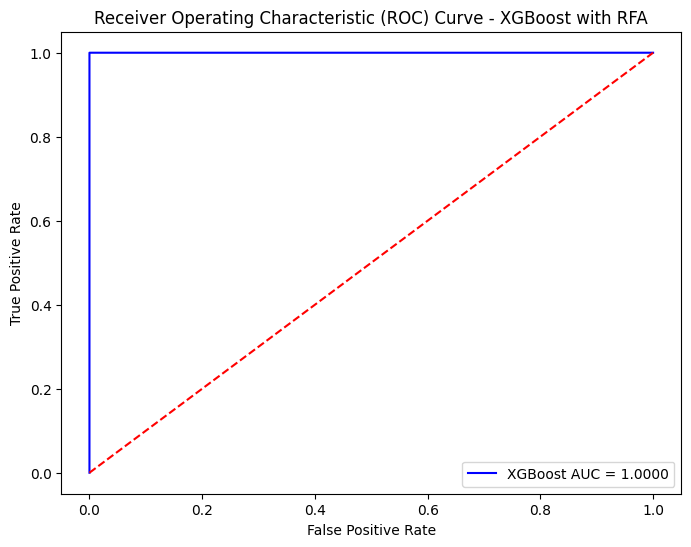

In [55]:
# Plot the ROC Curve
fpr_final, tpr_final, thresholds_final = roc_curve(y_test, y_prob_final)
plt.figure(figsize=(8, 6))
plt.plot(fpr_final, tpr_final, color='blue', label=f'XGBoost AUC = {auc_final:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost with RFA')
plt.legend()
plt.show()